## Fell + Spohrleder (2014) n-gram Baseline Replication

In [1]:
import pandas as pd
english = pd.read_csv("../data/poptrag_lyrics_genres_corpus_filtered_english.csv")

### Preprocessing and n-gram Feature Extraction
1. extract unigram, bigram, and trigram features from the lyrics
- make lowercase, remove punctuation (except apostrophes)
- contractions like "don't" should not be split during tokenization
2. calculate n-gram tf-idf for all n-grams with genres (cat[n]) as documents (frequency +1 per tracks that contiain the n-gram) 
3. rank all n-grams by tf-idf score within each genre
4. "downrank artist specific ngrams" by removing n-grams that occur in less than x? (e.g, 50) different artists
5. per genre and n, select top 100 n-grams as binary features (present / not present in lyrics) (produces 2700 features max for 9 genres; might be less due to overlaps)

In [ ]:
from helpers.n_gram_features import build_ngram_features
build_ngram_features(corpus=english, granularity=5, min_artists=50, top_n=100)

Hello World!


In [ ]:
from helpers.n_gram_features import build_ngram_features
build_ngram_features(corpus=english, granularity=12, min_artists=50, top_n=100)

In [ ]:
from helpers.n_gram_features import build_ngram_features
build_ngram_features(corpus=english, granularity=25, min_artists=50, top_n=100)

In [ ]:
from helpers.n_gram_features import build_ngram_features
build_ngram_features(corpus=english, granularity=32, min_artists=50, top_n=100)

## Train SVM Model 
- what should be implemented for the baseline? 
    1. save components for inspection in report: 
        - model (use logistic regression with elastic net regularization for better interpretability) 
        - model coefficients
        - train data and test data splits (with genre labels, wout features, for distributions comparison)
        - predictions vs true labels on test data for evaluation and conf mat
    2. implement up and downsampling with Nearmiss and Borderline Smote in an imbalanced Pipeline; train penalty and L1/L2 ratio as well as adaptive sampling (see below for explanation on target ratio)  
    3. implement a Bayesian hyperparameter optimization (with Latin Hypercube initial grid) for the model and sampling strategies => select the model using the one standard error rule on the validation set (model with highest penalty within one standard error of the best model in terms of macro f1); after finding the best parameters with 5-fold CV, retrain on full training set and evaluate on test set
    4. implement a full evaluation pipeline with classification report, conf mat, and visualizations 


In [11]:
import pandas as pd

labels_and_artists = pd.read_csv(
    "../../data/poptrag_lyrics_genres_corpus_filtered_english.csv"
)
features5 = pd.read_csv("../../data/FS_G5_lyrics_n_gram_features.csv")

In [14]:
from helpers.split_group_stratified_and_join import (
    split_group_stratified_and_join,
    plot_genre_distribution,
)
from helpers.subsample_training_data import draw_stratified_subsample

granularity = 5
SEED = 42

labels_and_artists.rename(
    columns={"track.s.firstartist.name": "group", f"cat{granularity}": "label"},
    inplace=True,
)
labels_and_artists = labels_and_artists[["group", "label"]]

X_train, X_test, y_train, y_test = split_group_stratified_and_join(
    labels_and_artists, features5, test_size=0.2, random_state=SEED
)

X_train_sub, y_train_sub = draw_stratified_subsample(
    X_train, y_train, frac=0.05, random_state=SEED
)
# randomly sample 10% of features from X_train_sub and the same from X_test
X_train_sub = X_train_sub.sample(
    frac=0.1, axis=1, random_state=SEED
)
X_test = X_test[X_train_sub.columns]
print(X_train_sub.shape)

(4541, 58)


(4541, 579)


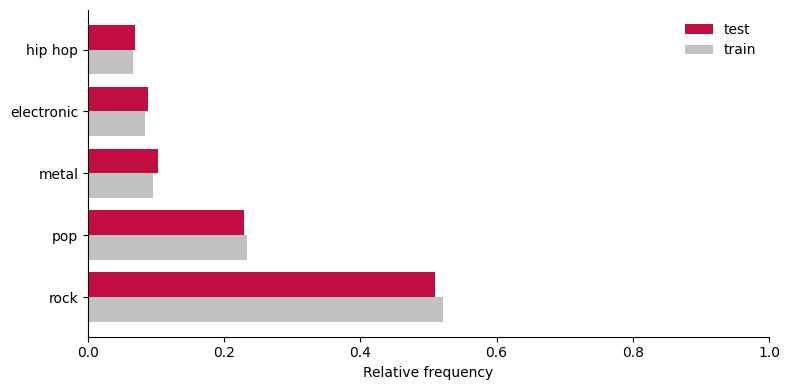

In [ ]:
dist = plot_genre_distribution(y_train, y_test)


In [ ]:
from helpers.training_pipeline import (
    train_model_with_optimization,
    evaluate_model,
    save_training_artifacts,
    visualize_results
)

param_space = {
    'C': [-3, 2],
    'l1_ratio': [0, 1],
    'target_ratio': [0.08, 0.48]
}

best_pipeline, optimization_results = train_model_with_optimization(
    X_train_sub,
    y_train_sub,
    param_space=param_space,
    n_initial=3,
    n_iterations=2,
    cv=3,
    random_state=SEED, 
    n_jobs=-1, 
    checkpoint_dir="./checkpoints_ngram_granularity_5"
)

print(f"\nBest parameters (1-SE rule): {optimization_results['best_params']}")
print(f"Best CV score: {optimization_results['best_score']:.4f}")
print(f"\nAbsolute best parameters: {optimization_results['absolute_best_params']}")
print(f"Absolute best score: {optimization_results['absolute_best_score']:.4f}")

Starting Initial Phase:
Using -1 parallel jobs
Initial evaluation 1/3
Score: 0.2247
------------------------------------------------------------
Initial evaluation 2/3
Score: 0.2609
------------------------------------------------------------
Initial evaluation 3/3
Score: 0.2908
------------------------------------------------------------
Starting Bayesian Phase:
Bayesian iteration 1/2
Score: 0.2878
------------------------------------------------------------
Bayesian iteration 2/2
Score: 0.2865
------------------------------------------------------------
Selecting best parameters according to 1-SE rule...
Retraining best pipeline on full training data...


N:\Materialien\Promotion\LyricsGenreRecognition\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



Best parameters (1-SE rule): {'C': np.float64(81.90243383220366), 'l1_ratio': np.float64(0.7769999744349545), 'target_ratio': np.float64(2.356233164669193)}
Best CV score: 0.2878

Absolute best parameters: {'C': np.float64(5.388077452832789), 'l1_ratio': np.float64(0.40464523157434873), 'target_ratio': np.float64(2.9034756107975843)}
Absolute best score: 0.2908


N:\Materialien\Promotion\LyricsGenreRecognition\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [16]:
print("Evaluating on test set...")
evaluation_results = evaluate_model(best_pipeline, X_test, y_test)

print(f"\nTest set macro F1: {evaluation_results['macro_f1']:.4f}")
print("\nClassification Report:")
print(pd.DataFrame(evaluation_results['classification_report']).transpose())

Evaluating on test set...

Test set macro F1: 0.2798

Classification Report:
              precision    recall  f1-score       support
electronic     0.085526  0.020867  0.033548   1869.000000
hip hop        0.267267  0.183002  0.217250   1459.000000
metal          0.308992  0.284538  0.296261   2186.000000
pop            0.293624  0.599175  0.394114   4850.000000
rock           0.546146  0.393810  0.457634  10759.000000
accuracy       0.382095  0.382095  0.382095      0.382095
macro avg      0.300311  0.296278  0.279761  21123.000000
weighted avg   0.403603  0.382095  0.372221  21123.000000


In [8]:
output_dir = save_training_artifacts(
    best_pipeline,
    optimization_results,
    evaluation_results,
    X_train_sub,
    y_train_sub,
    X_test,
    y_test,
    output_dir=f'../../models/fell_sporleder_baseline_g{granularity}'
)

print(f"Artifacts saved to: {output_dir}")

Artifacts saved to: ..\..\models\fell_sporleder_baseline_g5


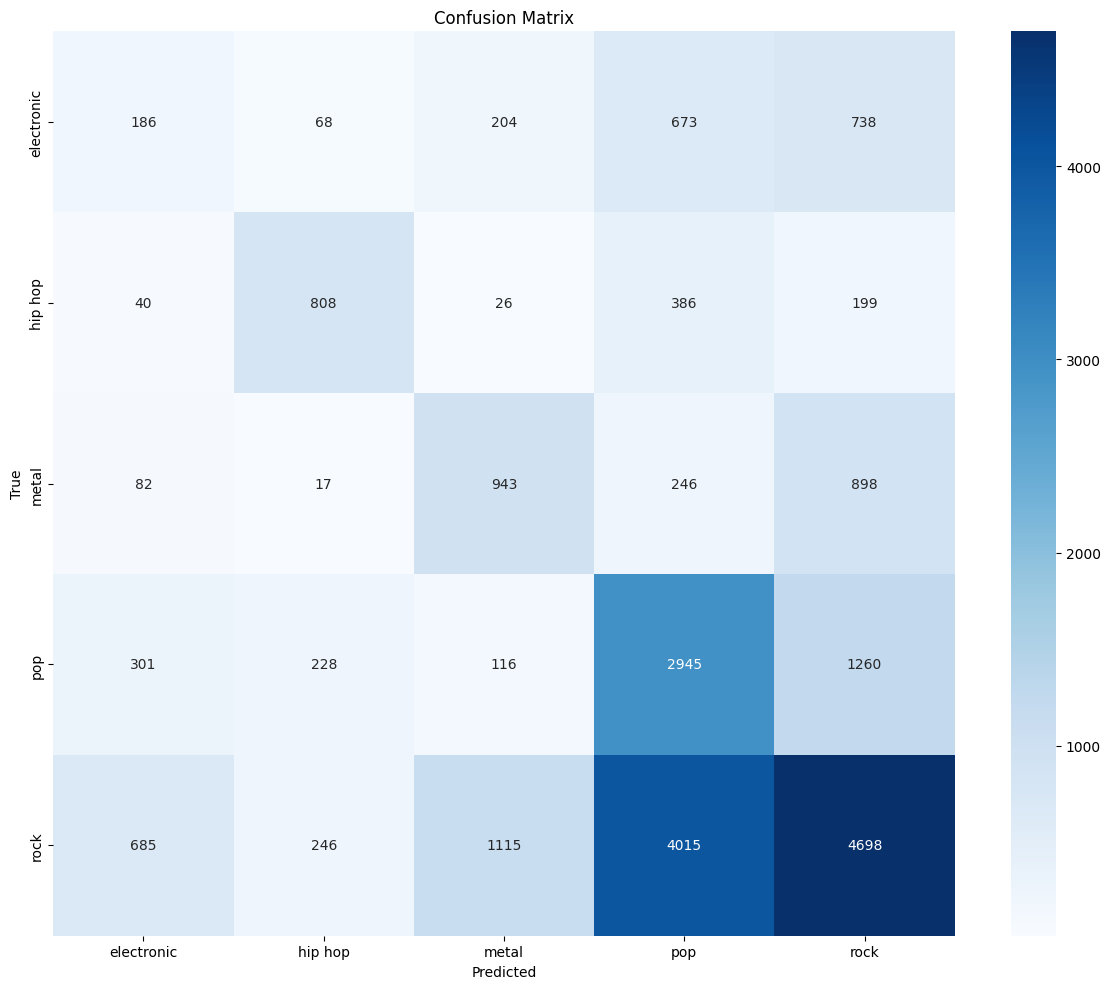

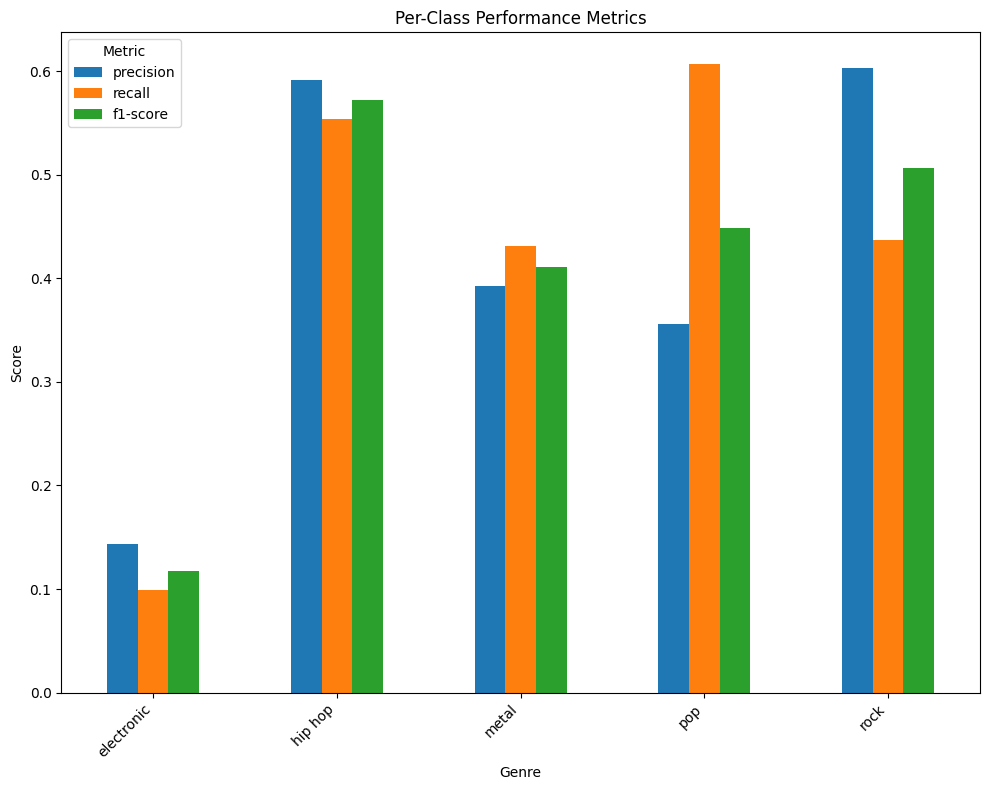

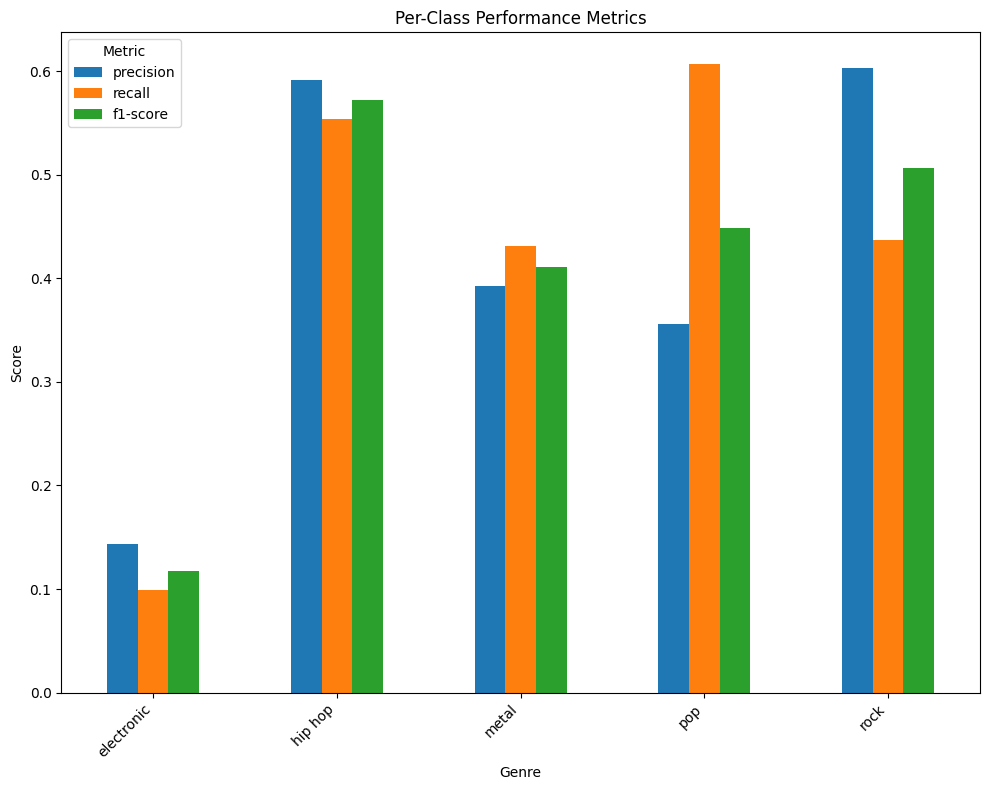

In [9]:
visualize_results(evaluation_results, y_test, output_dir=output_dir)

### Optimization Progress Visualization

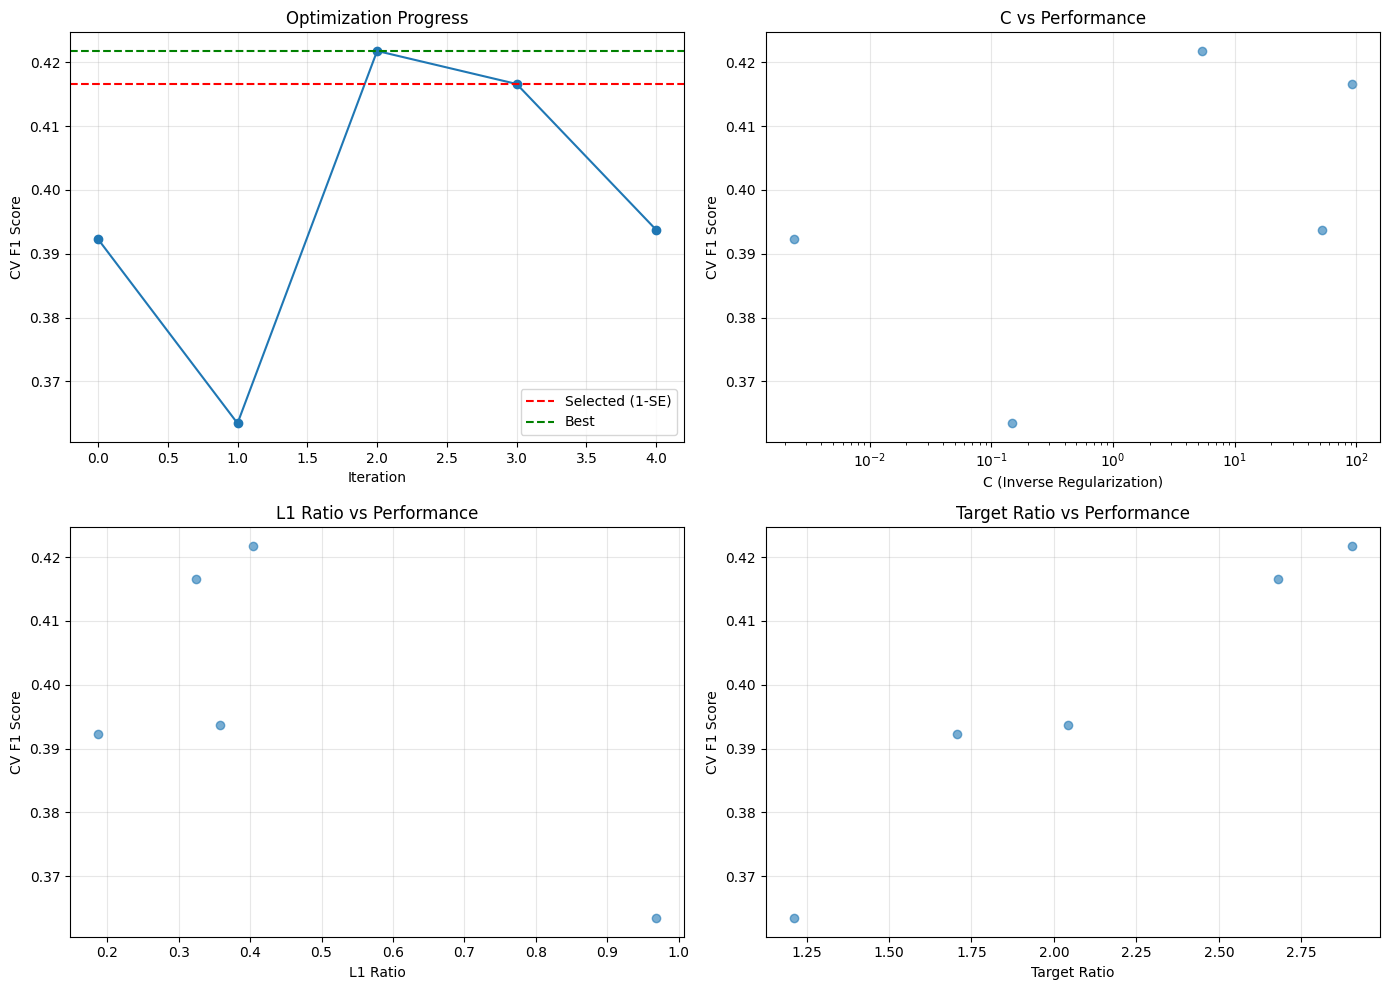

In [10]:
import matplotlib.pyplot as plt
import numpy as np

results_df = pd.DataFrame([
    {
        'iteration': i,
        'score': r['score'],
        'C': r['params']['C'],
        'l1_ratio': r['params']['l1_ratio'],
        'target_ratio': r['params']['target_ratio']
    }
    for i, r in enumerate(optimization_results['all_results'])
])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(results_df['iteration'], results_df['score'], 'o-')
axes[0, 0].axhline(
    optimization_results['best_score'],
    color='r',
    linestyle='--',
    label='Selected (1-SE)'
)
axes[0, 0].axhline(
    optimization_results['absolute_best_score'],
    color='g',
    linestyle='--',
    label='Best'
)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('CV F1 Score')
axes[0, 0].set_title('Optimization Progress')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(results_df['C'], results_df['score'], alpha=0.6)
axes[0, 1].set_xlabel('C (Inverse Regularization)')
axes[0, 1].set_ylabel('CV F1 Score')
axes[0, 1].set_title('C vs Performance')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(results_df['l1_ratio'], results_df['score'], alpha=0.6)
axes[1, 0].set_xlabel('L1 Ratio')
axes[1, 0].set_ylabel('CV F1 Score')
axes[1, 0].set_title('L1 Ratio vs Performance')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(results_df['target_ratio'], results_df['score'], alpha=0.6)
axes[1, 1].set_xlabel('Target Ratio')
axes[1, 1].set_ylabel('CV F1 Score')
axes[1, 1].set_title('Target Ratio vs Performance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'optimization_progress.png', dpi=300)
plt.show()